In [ ]:
# import functions
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import cv2

# ignore warning
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

# load data
X_train = np.load('./brats2021/brats_t1_img_train.npy')
X_test = np.load('./brats2021/brats_t1_img_eval.npy')

X_train = X_train - np.min(X_train)
X_train = X_train / np.max(X_train)

X_test = X_test - np.min(X_test)
X_test = X_test / np.max(X_test)

y_train = np.load('./brats2021/brats_t1_labels_train.npy')
y_test = np.load('./brats2021/brats_t1_labels_eval.npy')

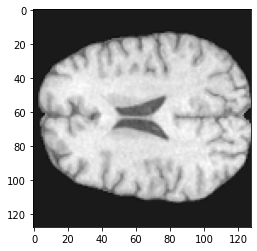

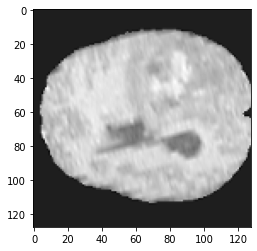

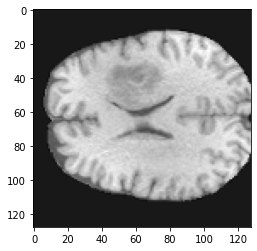

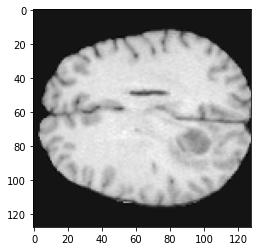

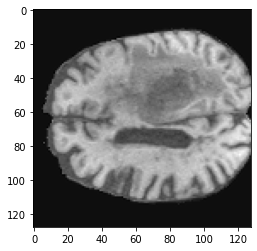

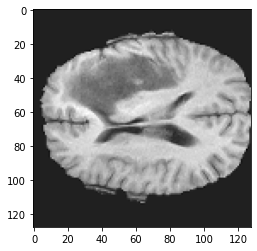

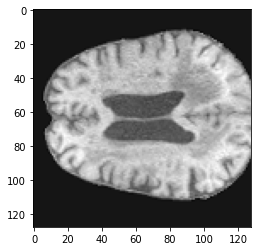

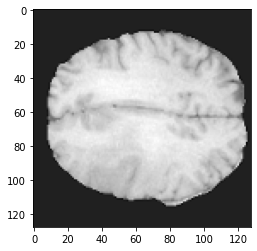

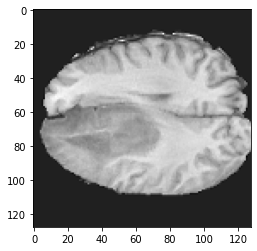

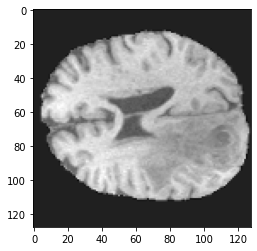

In [ ]:
for i in range(0, 10):
  plt.imshow(X_train[-i, :, :], cmap="gray")
  plt.show()

In [ ]:
# Define pneumonia dataset class
class Dataset(Dataset):
    def __init__(self, data, background_targets):
        self.data = torch.from_numpy(data.astype(float)).float()
        self.background_targets = torch.from_numpy(background_targets.astype(float)).float()

    def __len__(self):
        return len(self.background_targets)

    def __getitem__(self, index: int):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        img, background_target_label = self.data[index][None, :, :], int(self.background_targets[index])

        return img, background_target_label

# Instantiate Dataset and Data Loader
train_dataset = Dataset(X_train, y_train)
test_dataset = Dataset(X_test, y_test)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=512, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=512)


In [ ]:
class View(nn.Module):
    def __init__(self, size):
        super(View, self).__init__()
        self.size = size

    def forward(self, tensor):
        return tensor.view(self.size)

class Encoder(nn.Module):
    def __init__(self, background_latent_size, salient_latent_size):
        super(Encoder, self).__init__()

        # encoder
        hidden_dim = 512

        self.bg_encoder = nn.Sequential(
            nn.Conv2d(1, 32, 4, 2, 1),
            nn.ReLU(True),
            nn.Conv2d(32, 32, 4, 2, 1),
            nn.ReLU(True),
            nn.Conv2d(32, 64, 4, 2, 1),
            nn.ReLU(True),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.ReLU(True),
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.ReLU(True),
            nn.Conv2d(256, hidden_dim, 4, 1),
            nn.ReLU(True),
            View((-1, hidden_dim)),
            nn.Linear(hidden_dim, background_latent_size * 2),
        )

        self.bg_locs = nn.Linear(background_latent_size * 2, background_latent_size)
        self.bg_scales = nn.Linear(background_latent_size * 2, background_latent_size)

        self.tg_encoder = nn.Sequential(
            nn.Conv2d(1, 32, 4, 2, 1),
            nn.ReLU(True),
            nn.Conv2d(32, 32, 4, 2, 1),
            nn.ReLU(True),
            nn.Conv2d(32, 64, 4, 2, 1),
            nn.ReLU(True),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.ReLU(True),
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.ReLU(True),
            nn.Conv2d(256, hidden_dim, 4, 1),
            nn.ReLU(True),
            View((-1, hidden_dim)),
            nn.Linear(hidden_dim, salient_latent_size * 2),
        )

        self.tg_locs = nn.Linear(salient_latent_size * 2, salient_latent_size)
        self.tg_scales = nn.Linear(salient_latent_size * 2, salient_latent_size)

    def forward(self, x):
        hz = F.relu(self.bg_encoder(x))
        hs = F.relu(self.tg_encoder(x))

        return self.bg_locs(hz), self.bg_scales(hz), self.tg_locs(hs), self.tg_scales(hs)


class Decoder(nn.Module):
    def __init__(self, background_latent_size, salient_latent_size):
        super(Decoder, self).__init__()

        hidden_dim = 512
        self.decoder = nn.Sequential(
            nn.Linear(background_latent_size + salient_latent_size, hidden_dim),
            View((-1, hidden_dim, 1, 1)),
            nn.ReLU(True),
            nn.ConvTranspose2d(hidden_dim, 512, 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 1, 4, 2, 1),
            nn.Sigmoid()
        )

    def forward(self, z):
        return self.decoder(z)


class Classifier(nn.Module):
    def __init__(self, latent_dim):
        super(Classifier, self).__init__()
        self.z_dim = latent_dim
        self.fc = nn.Sequential(nn.Linear(self.z_dim, self.z_dim), nn.ReLU(), nn.Linear(self.z_dim, 1))

    def forward(self, latent):
        latent = latent.view(-1, self.z_dim)
        h = self.fc(latent)
        pred = torch.sigmoid(h)
        return pred

class FactorClassifier(nn.Module):
    def __init__(self, latent_dim):
        super(FactorClassifier, self).__init__()
        self.z_dim = latent_dim
        self.fc = nn.Sequential(nn.Linear(self.z_dim, self.z_dim), nn.ReLU(), nn.Linear(self.z_dim, self.z_dim), nn.ReLU(), nn.Linear(self.z_dim, 1))

    def forward(self, latent):
        latent = latent.view(-1, self.z_dim)
        h = self.fc(latent)
        pred = torch.sigmoid(h)
        return pred


In [ ]:
# hyper-parameter
common_size=128
salient_size=128
alpha = 1/0.01
beta_c = 1
beta_s = 0.1
kappa = 10
gamma = 1e-8

## create loss function
bce = nn.BCELoss(reduction="sum")
def compute_loss(x_reconstructed, x, z_mean, z_log_var, y, y_pred):
    # elbo loss
    reconstruction_loss = (x[y==1] - x_reconstructed[y==1]).pow(2).sum()
    reconstruction_loss += (x[y==0] - x_reconstructed[y==0]).pow(2).sum()

    kl_div_loss = - beta_c * 0.5 * torch.sum(1 + z_log_var[y==0, :common_size] - z_mean[y==0, :common_size].pow(2) - z_log_var[y==0, :common_size].exp(), dim=-1).sum()
    kl_div_loss += - beta_c * 0.5 * torch.sum(1 + z_log_var[y==1, :common_size] - z_mean[y==1, :common_size].pow(2) - z_log_var[y==1, :common_size].exp(), dim=-1).sum()
    kl_div_loss += - beta_s * 0.5 * torch.sum(1 + z_log_var[y==1, common_size:] - z_mean[y==1, common_size:].pow(2) - z_log_var[y==1, common_size:].exp(), dim=-1).sum()
    kl_div_loss += beta_s * alpha * 0.5 * z_mean[y==0, common_size:].pow(2).sum()

    clsf_loss = bce(y_pred, y[:, None])

    return reconstruction_loss, kl_div_loss, clsf_loss


class ShallowDisVAE(nn.Module):
    """ The VAE architecture.
    """

    def __init__(self, background_latent_size, salient_latent_size, sigma_q=0.1):
        super(ShallowDisVAE, self).__init__()

        total_latent_size = background_latent_size + salient_latent_size
        self.common_size = background_latent_size
        self.salient_size = salient_latent_size
        self.total_latent_size = total_latent_size
        self.sigma_q=sigma_q

        self.encoder = Encoder(background_latent_size, salient_latent_size).float()
        self.decoder = Decoder(background_latent_size, salient_latent_size).float()
        self.classifier = Classifier(salient_latent_size).float()

    def forward(self, x, y):
        device = x.get_device()
        batch_size = x.size()[0]

        # compute the parameters of the posterior distribution
        mean_qzx, logvar_qzx, specific_mean_qzx, specific_logvar_qzx = self.encoder(x)
        specific_logvar_qzx[y==0] = torch.log(self.sigma_q*torch.ones_like(specific_logvar_qzx[y==0]))

        # common and specific latent vectors
        reparameterized_latent = torch.randn((batch_size, self.total_latent_size), device=device)

        # z latent space
        mean = torch.cat([mean_qzx, specific_mean_qzx], dim=1)
        logvar = torch.cat([logvar_qzx, specific_logvar_qzx], dim=1)
        std = (logvar * 0.5).exp()

        # sample latents
        z = mean + std * reparameterized_latent

        # classify on the latents
        y_pred = self.classifier(z[:, self.common_size:])

        # compute log probs for x
        z_zeroed = torch.clone(z)
        z_zeroed[y == 0, self.common_size:] = 0.0
        reconstructed_x = self.decoder(z_zeroed)

        return reconstructed_x, mean, logvar, y_pred, z

    def inference(self, x):
        # inference
        mean_qzx, logvar_qzx, specific_mean_qzx, specific_logvar_qzx = self.encoder(x)

        # z latent space
        mean = torch.cat([mean_qzx, specific_mean_qzx], dim=1)
        logvar = torch.cat([logvar_qzx, specific_logvar_qzx], dim=1)

        y_pred = self.classifier(specific_mean_qzx)

        return mean, logvar, y_pred


In [ ]:
def train(epoch, vae, optimizer, factor_optimizer):
    vae.train()
    train_loss = 0
    for batch_idx, (data, y) in enumerate(train_loader):
        data = data.cuda()
        y = y.cuda()

        # independent optimizer training
        factor_optimizer.zero_grad()
        _, _, _, _, z = vae(data, y)

        # common classifiacation training
        y_pred_common = common_classifier(z[:, :common_size])
        fader_clsf_loss = bce(y_pred_common, y[:, None].float())

        # total correlation discriminator training
        joint_predictions = factor_classifier(z)
        product_of_marginals_predictions = factor_classifier(torch.cat((z[:, :common_size], torch.cat((z[1:, common_size:], z[0, common_size:][None]), dim=0)), dim=1))
        factor_input = torch.cat((joint_predictions[:, 0], product_of_marginals_predictions[:, 0]), dim=0)
        factor_target = torch.cat((torch.ones_like(joint_predictions[:, 0]), torch.zeros_like(product_of_marginals_predictions[:, 0])), dim=0)
        factor_clsf_loss = bce(factor_input, factor_target)

        # parameters update
        loss = factor_clsf_loss + fader_clsf_loss
        loss.backward()
        factor_optimizer.step()

        # training of the vae model
        optimizer.zero_grad()
        reconstructed_x, z_mean, z_log_var, y_pred, z = vae(data, y)
        reconstruction_loss, kl_div_loss, clsf_loss = compute_loss(reconstructed_x, data, z_mean, z_log_var, y.float(), y_pred)

        joint_predictions = factor_classifier(z)
        factor_clsf_loss = F.relu(torch.log(joint_predictions / (1 - joint_predictions))).sum()

        # parameters training
        loss = reconstruction_loss + kl_div_loss + kappa*factor_clsf_loss + gamma*clsf_loss
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    print(train_loss / len(train_loader))

def test(vae):
    y_s = []
    y_preds = []
    y_pred_commons = []
    factor_s = []
    factor_pred = []
    vae.eval()
    with torch.no_grad():
        for data, y in test_loader:
            data = data.cuda()
            y = y.cuda()

            z_mean, z_log_var, y_pred = vae.inference(data)

            y_pred_common = common_classifier(z_mean[:, :common_size])
            y_pred_commons.append(y_pred_common[:, 0].round().int())

            joint_predictions = factor_classifier(z_mean)
            product_of_marginals_predictions = factor_classifier(torch.cat((z_mean[:, :common_size], torch.cat((z_mean[1:, common_size:], z_mean[0, common_size:][None]), dim=0)), dim=1))
            factor_pred.append(joint_predictions[:, 0].round().int())
            factor_pred.append(product_of_marginals_predictions[:, 0].round().int())
            factor_s.append(torch.ones_like(joint_predictions[:, 0]))
            factor_s.append(torch.zeros_like(joint_predictions[:, 0]))

            y_preds.append(y_pred[:, 0])
            y_s.append(y.int())

    y_preds = torch.cat(y_preds, dim=0)
    y_s = torch.cat(y_s, dim=0)
    bacc = roc_auc_score(y_s.cpu().numpy(), y_preds.cpu().numpy())
    print("TEST B-ACC : ", bacc)

    y_pred_commons = torch.cat(y_pred_commons, dim=0)
    bacc = balanced_accuracy_score(y_s.cpu().numpy(), y_pred_commons.cpu().numpy())
    print("TEST COMMON B-ACC : ", bacc)

    factor_pred = torch.cat(factor_pred, dim=0)
    factor_s = torch.cat(factor_s, dim=0)
    bacc = (factor_s == factor_pred).float().mean()
    print("TEST FACTOR B-ACC : ", bacc.item())


In [ ]:
# Training
for run in range(0) :
    print(run)
    # define the models
    factor_classifier = FactorClassifier(common_size + salient_size).float().cuda()
    common_classifier = Classifier(common_size).float().cuda()
    vae = ShallowDisVAE(common_size, salient_size).float().cuda()

    optimizer = torch.optim.Adam(vae.parameters())
    factor_optimizer = torch.optim.Adam(list(factor_classifier.parameters()) + list(common_classifier.parameters()))

    for epoch in range(1, 501):
        train(epoch, vae, optimizer, factor_optimizer)

        if epoch % 10 == 0:
          test(vae)
    print("----------")


In [ ]:
vae = torch.load("./brats2021/vae.pth")

In [ ]:
# reconstruction results

vae.eval()

for idx in range(len(X_test)) :
  if idx > 0 :
    idx=-idx
    print(y_test[idx])
      
    plt.imshow(X_test[idx], cmap="gray")
    plt.axis('off') 
    plt.show()

    mean, _, _ = vae.inference(torch.tensor(X_test[idx])[None].cuda().float())
    recontructed_x = vae.decoder(mean).detach().cpu().numpy()[0][0]

    plt.imshow(recontructed_x, cmap="gray")
    plt.axis('off') 
    plt.show()

    mean[:, 128:] = 0
    recontructed_x_healthy = vae.decoder(mean).detach().cpu().numpy()[0][0]

    plt.imshow(recontructed_x_healthy, cmap="gray")
    plt.axis('off') 
    plt.show()

    print("---------------------------------")

In [ ]:
# generation results

vae.eval()

mean = torch.randn(16, 256).cuda()
reconstructed_x = vae.decoder(mean).detach().cpu().numpy()[:, 0]
mean[:, 128:] = 0
reconstructed_x_healthy = vae.decoder(mean).detach().cpu().numpy()[:, 0]

for idx in range(len(reconstructed_x)) :
  f, axarr = plt.subplots(1, 2)
  axarr[0].imshow(reconstructed_x_healthy[idx], cmap="gray")
  plt.axis('off') 
  axarr[1].imshow(reconstructed_x[idx], cmap="gray")
  plt.axis('off') 
  plt.show()

  print("---------------------------------")